In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random
import zipfile

from tqdm import tqdm   # Progress bar
from IPython.display import Audio, display

import cv2

import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset

random.seed(6)
np.random.seed(6)
torch.manual_seed(6)
torch.cuda.manual_seed(6)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
def allDone():
    display(Audio(url='../../chicken.mp3', autoplay=True))

In [3]:
train_val_labels = pd.read_csv('../input/train.csv')
train_val_labels.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


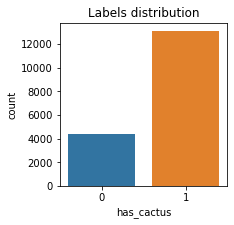

In [4]:
plt.figure(figsize=(3,3))
plt.title('Labels distribution')
sns.countplot(train_val_labels['has_cactus']);

In [5]:
# Вывод сэмплов на экран

def show_sample_images(dataloader, batch_size, images_from_batch=0):

    if images_from_batch == 0 or images_from_batch > batch_size:
            images_from_batch = batch_size
        
    for images, labels in dataloader:
        plt.figure(figsize=(20, (batch_size // 20 + 1) * 3))

        cols = 12
        rows = batch_size // cols + 1
        for i in range(images_from_batch):
            plt.subplot(rows, cols, i+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(images[i].permute(1, 2, 0)) # Размерность RGB в конец
            plt.xlabel(classes[labels[i].numpy()])
        plt.show()
        
        break

## Batch size!

In [6]:
batch_size = 250
# 500 неплохо, попробовать ещё (sched - 25 step)
# 250 - 99,48%
# 50 - 99,08%

train_dir = r'C:\Temp\train'
val_dir = r'C:\Temp\val'

classes = ['No', 'Cactus']

train_transforms = transforms.Compose([
    # transforms.RandomResizedCrop(224, scale=(0.75, 1.0)),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    # transforms.RandomResizedCrop(224, scale=(0.75, 1.0)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0)


# Протестировали загрузку, узнали размер тензора
for images, labels in train_dataloader:
    print(images.size())
    print(labels.size())
    break

torch.Size([250, 3, 32, 32])
torch.Size([250])


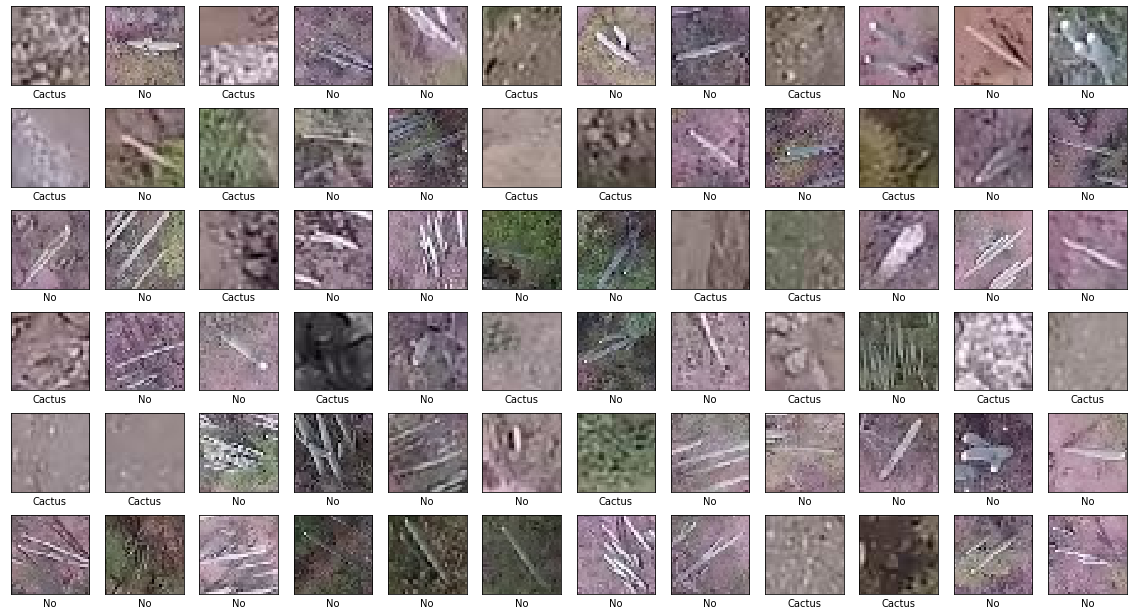

In [7]:
# Теперь посмотрим на картиночки

show_sample_images(train_dataloader, batch_size, 72)

In [8]:
print(f'Batch size: {batch_size}')
print(f'Train batches: {len(train_dataloader)}, Train samples: {len(train_dataset)}')
print(f'Val batches:   {len(val_dataloader)}, Val samples:    {len(val_dataset)}')

Batch size: 250
Train batches: 60, Train samples: 15000
Val batches:   10, Val samples:    2500


In [9]:
train_batch_loss_history = []
train_batch_accuracy_history = []

train_loss_history = []
train_accuracy_history = []

val_loss_history = []
val_accuracy_history = []

def validate(model, loss, optimizer):
        
    dataloader = val_dataloader
    model.eval()   # Set model to evaluate mode

    sum_loss = 0.
    sum_accuracy = 0.

    for inputs, labels in dataloader: # tqdm(dataloader):
        inputs = inputs.cuda()
        labels = labels.cuda()

        optimizer.zero_grad()

        with torch.set_grad_enabled(False):
            preds = model(inputs)
            loss_value = loss(preds, labels)
            preds_class = preds.argmax(dim=1)

        sum_loss += loss_value.item()
        sum_accuracy += (preds_class == labels.data).float().mean().cpu().numpy().item()

    val_loss = sum_loss / len(dataloader)
    val_accuracy = sum_accuracy / len(dataloader)

    val_loss_history.append(val_loss)
    val_accuracy_history.append(val_accuracy)
    
    print(f'Validation accuracy {val_accuracy * 100:.2f} %, loss {val_loss:.4f}')
#     if val_accuracy >= 0.99:
#         allDone()
#         input()

    model.train()  # Вернули как было


def train_model(model, loss, optimizer, scheduler, num_epochs):
        
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch}/{num_epochs-1}: \n', end='')

        dataloader = train_dataloader
        model.train()  # Set model to training mode

        sum_loss = 0.
        sum_accuracy = 0.

        # Прогон по батчам
        for inputs, labels in dataloader: #tqdm(dataloader):
            inputs = inputs.cuda()
            labels = labels.cuda()

            optimizer.zero_grad()

            # forward and backward
            with torch.set_grad_enabled(True):
                preds = model(inputs)
                loss_value = loss(preds, labels)
                preds_class = preds.argmax(dim=1)

                loss_value.backward()
                optimizer.step()
                # scheduler.step()

            batch_loss = loss_value.item()
            batch_accuracy = (preds_class == labels.data).float().mean().cpu().numpy().item()

            sum_loss += batch_loss
            sum_accuracy += batch_accuracy
            
            train_batch_loss_history.append(batch_loss)
            train_batch_accuracy_history.append(batch_accuracy)
            #print(f'\r----- {phase}, batch accuracy {train_batch_accuracy * 100:.2f} %, batch loss {train_batch_loss:.4f}')        
            #validate(model, loss, optimizer)
            
        epoch_loss = sum_loss / len(dataloader)
        epoch_acc = sum_accuracy / len(dataloader)

        train_loss_history.append(epoch_loss)
        train_accuracy_history.append(epoch_acc)
        scheduler.step()

        # Валидация
        print('\n End epoch: ', end='')
        validate(model, loss, optimizer)
        
    return model

In [10]:
class CactusNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #self.batch_norm0 = torch.nn.BatchNorm2d(1)
        # 32x32x3
        self.conv1_1 = torch.nn.Conv2d(3, 16, 3, padding=1)   # in_channels, out_channels, kernel_size
        self.conv1_2 = torch.nn.Conv2d(16, 16, 3, padding=1)
        self.batch_norm1 = torch.nn.BatchNorm2d(16)
        self.pool1 = torch.nn.MaxPool2d(4)
        # 8x8x16
        self.conv2_1 = torch.nn.Conv2d(16, 32, 3, padding=1)
        self.conv2_2 = torch.nn.Conv2d(32, 32, 3, padding=1)
        self.batch_norm2 = torch.nn.BatchNorm2d(32)
        self.pool2 = torch.nn.MaxPool2d(2)
        # 4x4x32
        self.conv3_1 = torch.nn.Conv2d(32, 64, 3, padding=1)
        self.conv3_2 = torch.nn.Conv2d(64, 64, 3, padding=1)
        self.batch_norm3 = torch.nn.BatchNorm2d(64)
        self.pool3 = torch.nn.MaxPool2d(2)
        # 2x2x64
        self.conv4_1 = torch.nn.Conv2d(64, 128, 3, padding=1)
        self.conv4_2 = torch.nn.Conv2d(128, 128, 3, padding=1)
        self.batch_norm4 = torch.nn.BatchNorm2d(128)
        self.pool4 = torch.nn.MaxPool2d(2)
        # 1x1x128  = 128
        self.drop1 = torch.nn.Dropout2d(p=0.5)

        #self.fc1 = torch.nn.Linear(128, 128)
        #self.batch_norm99 = torch.nn.BatchNorm1d(128)
        self.fc2 = torch.nn.Linear(128, 10)
        # self.ac3 = torch.nn.Softmax()   # Мы используем Cross-Entropy LOSS, а она принимает выходы и без Softmax

        self.relu = torch.nn.ReLU()
    
    def forward(self, x):
        #x = self.batch_norm0(x)
        x = self.conv1_1(x)
        x = self.relu(x)
        x = self.conv1_2(x)
        x = self.relu(x)
        x = self.batch_norm1(x)
        x = self.pool1(x)
        # print(x.shape)

        x = self.conv2_1(x)
        x = self.relu(x)
        x = self.conv2_2(x)
        x = self.relu(x)
        x = self.batch_norm2(x)
        x = self.pool2(x)
        # print(x.shape)

        x = self.conv3_1(x)
        x = self.relu(x)
        x = self.conv3_2(x)
        x = self.relu(x)
        x = self.batch_norm3(x)
        x = self.pool3(x)
        # print(x.shape)

        x = self.conv4_1(x)
        x = self.relu(x)
        x = self.conv4_2(x)
        x = self.relu(x)
        x = self.batch_norm4(x)
        x = self.pool4(x)

        
        x = self.drop1(x)

        #print(x.size(1), x.size(2), x.size(3))
        x = x.view(x.size(0), 128)
        
        # print(x.shape)
        #x = self.fc1(x)
        #x = self.relu(x)
        #x = self.batch_norm99(x)
        # print(x.shape)
        
        x = self.fc2(x)
        #x = self.ac3(x)
                
        return x

In [11]:
model = CactusNet()
#model = models.mobilenet_v2(pretrained=True)

# Disable grad for all conv layers - замораживаем слои ResNet
# for param in model.parameters():
#     param.requires_grad = False

# Заменяем последний слой на наш (512 входов, 2 выхода) (пересоздаём, поэтому будет разморожен)
#model.fc = torch.nn.Linear(model.fc.in_features, 2)
#model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 2)

model = model.cuda()

loss = torch.nn.CrossEntropyLoss() #weight=torch.FloatTensor([1, 1]).cuda())
optimizer = torch.optim.Adam(model.parameters())#, lr=1.0e-3, weight_decay=0.01, amsgrad=True)

#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40], gamma=0.1)  

In [12]:
print(f'Batch size: {batch_size}\nBatches: {len(train_dataloader)}\nAll elements: {len(train_dataset)}')

Batch size: 250
Batches: 60
All elements: 15000


In [13]:
# Тренировочка
epochs = int(np.sqrt(batch_size)) + 20  # Чтобы автоматически выбиралось

train_model(model, loss, optimizer, scheduler, num_epochs=epochs)
allDone()


Epoch 0/34: 

 End epoch: Validation accuracy 31.24 %, loss 2.6472

Epoch 1/34: 

 End epoch: Validation accuracy 97.52 %, loss 0.0682

Epoch 2/34: 

 End epoch: Validation accuracy 96.32 %, loss 0.1128

Epoch 3/34: 

 End epoch: Validation accuracy 93.88 %, loss 0.1801

Epoch 4/34: 

 End epoch: Validation accuracy 98.16 %, loss 0.0479

Epoch 5/34: 

 End epoch: Validation accuracy 98.04 %, loss 0.0488

Epoch 6/34: 

 End epoch: Validation accuracy 98.92 %, loss 0.0404

Epoch 7/34: 

 End epoch: Validation accuracy 98.20 %, loss 0.0504

Epoch 8/34: 

 End epoch: Validation accuracy 95.96 %, loss 0.1467

Epoch 9/34: 

 End epoch: Validation accuracy 88.72 %, loss 0.4485

Epoch 10/34: 

 End epoch: Validation accuracy 98.48 %, loss 0.0579

Epoch 11/34: 

 End epoch: Validation accuracy 97.92 %, loss 0.0758

Epoch 12/34: 

 End epoch: Validation accuracy 99.16 %, loss 0.0377

Epoch 13/34: 

 End epoch: Validation accuracy 94.72 %, loss 0.2129

Epoch 14/34: 

 End epoch: Validation accur

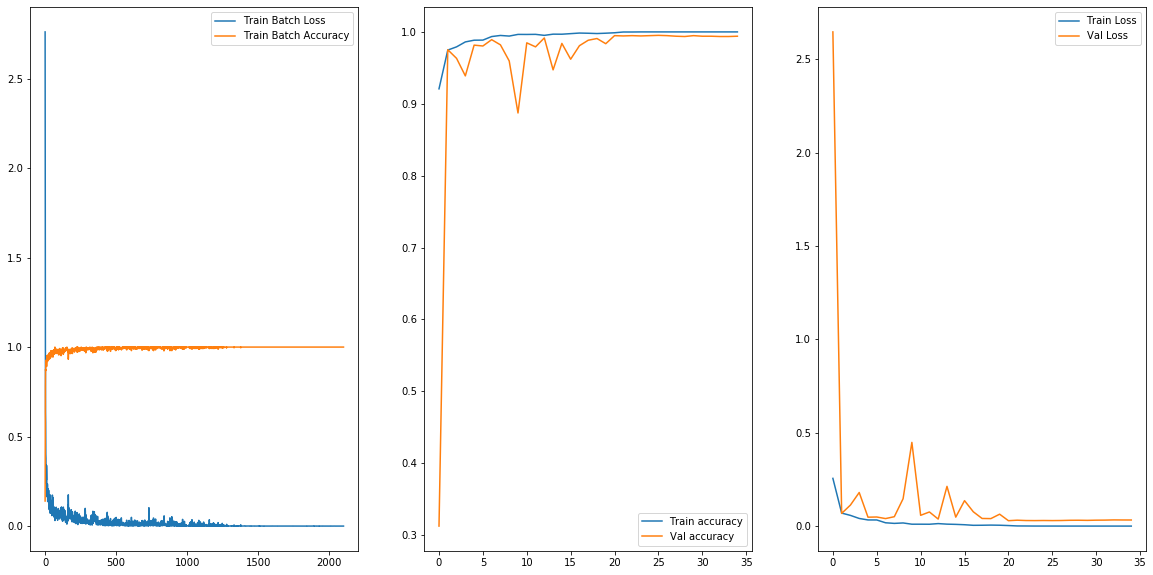

In [14]:
plt.figure(figsize=(20,10))
    
plt.subplot(1, 3, 1)
plt.plot(train_batch_loss_history, label='Train Batch Loss')
plt.plot(train_batch_accuracy_history, label='Train Batch Accuracy')
plt.legend();

plt.subplot(1, 3, 2)
plt.plot(train_accuracy_history, label='Train accuracy')
plt.plot(val_accuracy_history, label='Val accuracy')
plt.legend();
    
plt.subplot(1, 3, 3)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.legend();